In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
held_in_session_ids=["MonkeyG_20150925_Session2_S1"]
# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 60])
Test
torch.Size([2500, 20, 60])


In [4]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
    
cfg.training.epochs = 12001
cfg.tbfm.module.basis_depth = 3
cfg.tbfm.training.lambda_fro = 0.04
cfg.tbfm.training.lambda_ortho = 0.00
cfg.ae.training.optim.lr = 1e-4
cfg.tbfm.module.basis_gen_dropout = 0.3

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [5]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)

---- 0 1.1344636678695679 0.8021709322929382 0.46807900071144104 0.5856541395187378
---- 1000 0.42595499753952026 0.6599587798118591 0.5792708992958069 0.6595038771629333
---- 2000 0.39428818225860596 0.616489827632904 0.6163728833198547 0.6816339492797852
---- 3000 0.37754687666893005 0.5989726781845093 0.6353560090065002 0.690608561038971
---- 4000 0.3565519452095032 0.6017056107521057 0.659049391746521 0.6889810562133789
---- 5000 0.35160958766937256 0.5950403809547424 0.6665568947792053 0.6924287676811218
---- 6000 0.3458777368068695 0.6206478476524353 0.6768065690994263 0.679208517074585
---- 7000 0.3083834946155548 0.5941872000694275 0.715909481048584 0.692837655544281
---- 8000 0.31123578548431396 0.6041755080223083 0.7153192758560181 0.6876491904258728
---- 9000 0.33549821376800537 0.6241136193275452 0.7052772045135498 0.6773988604545593
---- 10000 0.2946041524410248 0.6231729388237 0.7350860238075256 0.6777944564819336
---- 11000 0.28760287165641785 0.604901134967804 0.7439670

In [15]:
for i in results["test_r2s"]:
    print(i)
print(results["final_test_r2"])

(0, 0.6209700107574463)
(1000, 0.684326171875)
(2000, 0.7028847336769104)
(3000, 0.7079055309295654)
(4000, 0.7057105302810669)
(5000, 0.7057698965072632)
(6000, 0.7030632495880127)
(7000, 0.6973609924316406)
0.6954635381698608


In [ ]:
# @ 7k:
#  3, 0.03, 0.1: 0.6994922161102295
#  3, 0.03, 0.2: 0.6973569393157959

#  3, 0.02, 0.1: 0.6971961259841919
#  2, 0.03, 0.1: 0.6959991455078125

In [6]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150925_Session2_S1': 0.6991660594940186}
0.6991660594940186


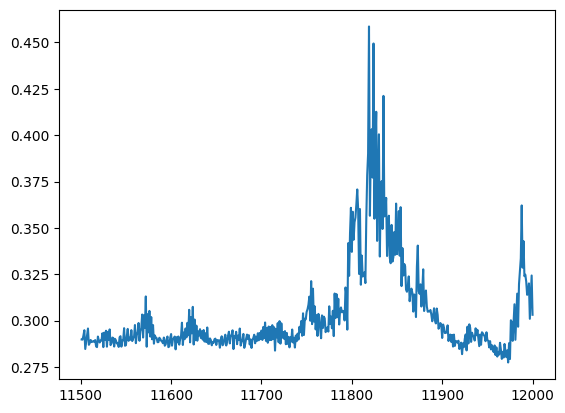

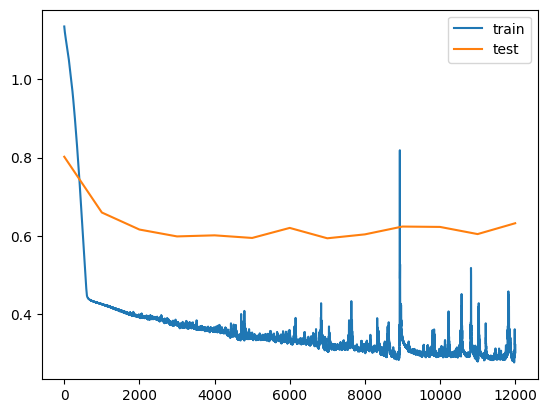

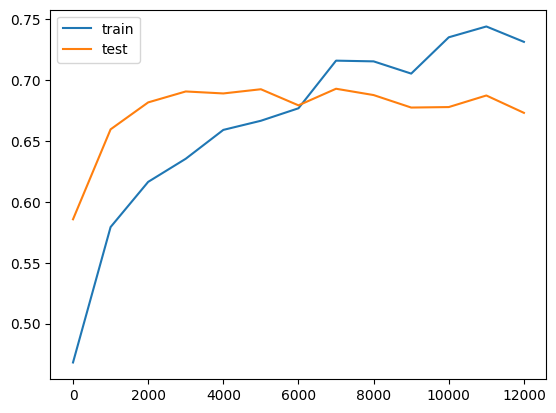

In [6]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [19]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([-0.0614,  0.0382,  0.0541, -0.0395, -0.1412,  0.0947, -0.0753,  0.0451,
         0.0889, -0.0264, -0.0923,  0.0926,  0.0201,  0.0646, -0.2211],
       device='cuda:0')
tensor([-0.0186, -0.1713, -0.0534, -0.1216, -0.0148,  0.0678, -0.0646, -0.0792,
         0.1374, -0.1338,  0.0144, -0.0022, -0.0586, -0.0244,  0.0698],
       device='cuda:0')


tensor([-0.9997, -1.0322, -1.0257, -1.0379, -1.0268, -1.0340, -0.9968, -1.0532,
        -0.9960, -1.0170], device='cuda:0')
------
------
tensor([-2.1811,  1.6760, -1.7858, -3.5046, -3.3603,  4.1201,  2.2647,  3.1186,
         3.3631, -1.9484], device='cuda:0') tensor([-3.5155,  2.9949, -1.8595, -5.9063, -4.5061,  6.3745,  3.2450,  4.4426,
         4.5735, -1.5487], device='cuda:0')
tensor([-1.0052, -1.0109, -1.0116, -1.0275, -1.0287, -1.0142, -1.0482, -1.0356,
        -1.0142, -1.0225], device='cuda:0')


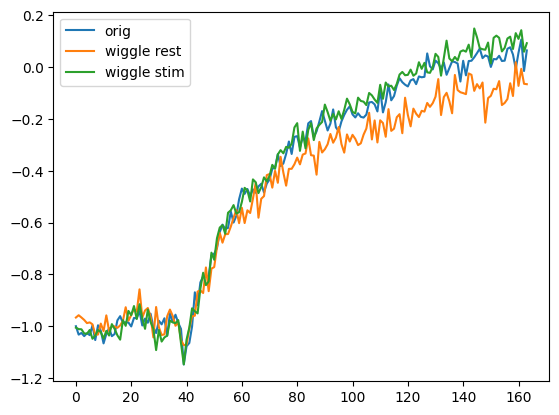

In [7]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]


def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 1.2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


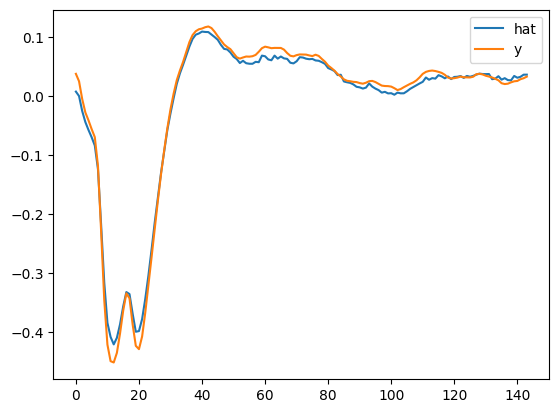

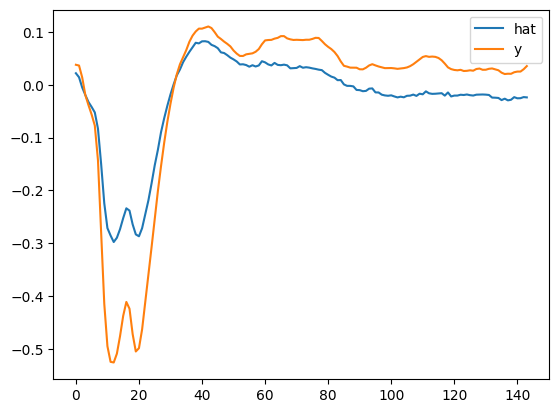

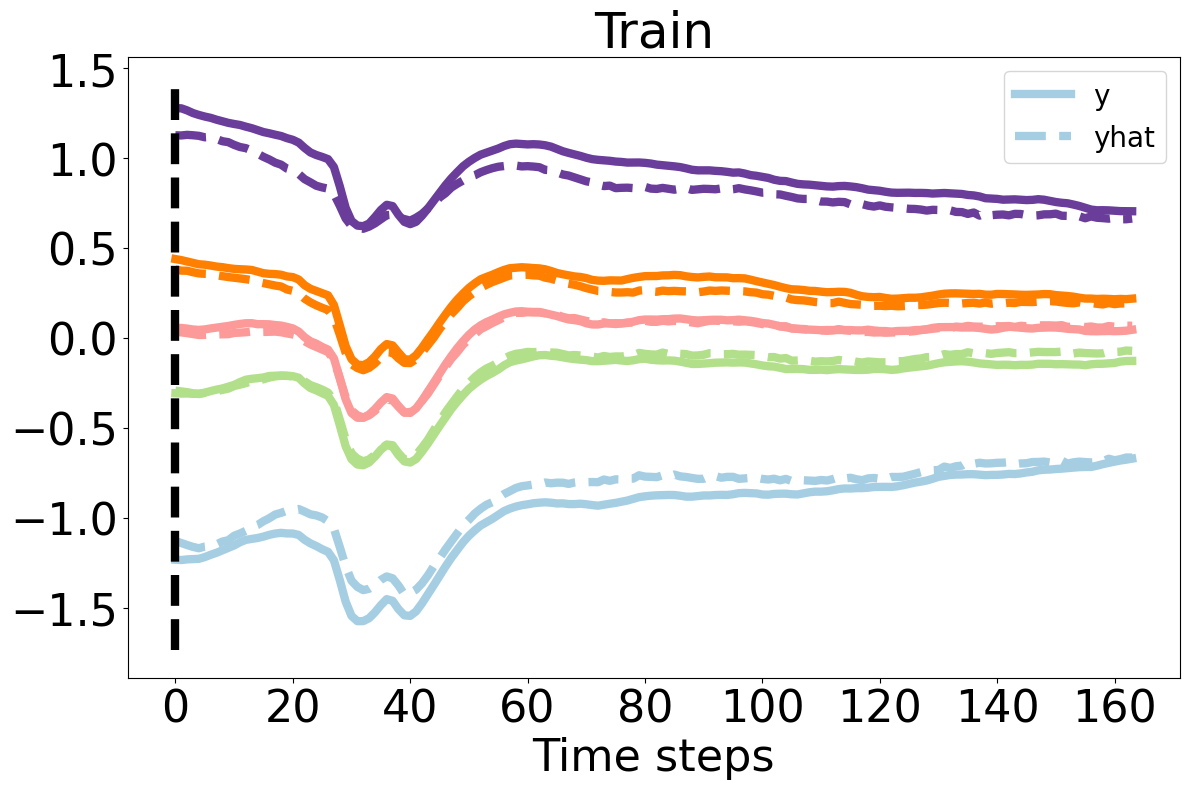

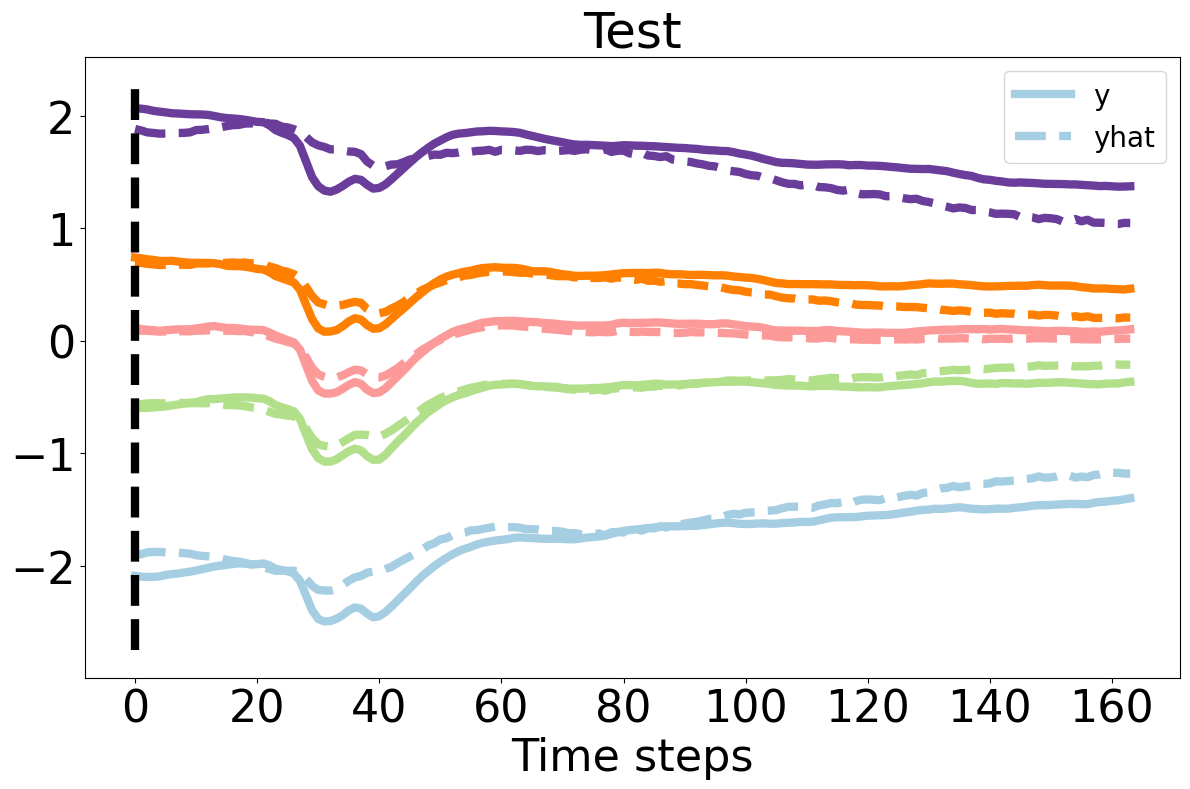

In [8]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=22)

In [ ]:
# Try:
# cfg.tbfm.module.latent_dim = (16, 32, 64)
# cfg.tbfm.module.embed_dim_stim = (3, 7, 15, 20)

for latent_dim in (16, 32, 64):
    for embed_dim_stim in (3, 7, 15, 20):
        print("---------------", latent_dim, embed_dim_stim)

        # cfg.tbfm.training.lambda_fro = regweight
        # cfg.tbfm.module.num_bases = num_bases
        # cfg.training.grad_clip = grad_clip
        # cfg.latent_dim = latent_dim
        # cfg.tbfm.training.optim.lr_head = lr_head
        # cfg.tbfm.training.lambda_ortho = lambda_ortho
        cfg.tbfm.module.latent_dim = latent_dim
        cfg.tbfm.module.embed_dim_stim = embed_dim_stim
        # cfg.tbfm.module.use_film_bases = True
        # cfg.ae.training.coadapt = True
        cfg.training.epochs = 15001

        ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
        model_optims = multisession.get_optims(cfg, ms)
        
        embeddings_stim, results = multisession.train_from_cfg(
            cfg,
            ms,
            data_train,
            model_optims,
            embeddings_rest,
            data_test=data_test,
            test_interval=5000,
            epochs=cfg.training.epochs,
            )
        torch.save(results, f"res_{latent_dim}_{embed_dim_stim}.torch")

        del model_optims, ms

--------------- 16 3
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1575546264648438 0.9233913421630859 0.0376604589788864 0.062086887657642365
---- 5000 0.5894997715950012 0.5439465641975403 0.4358087678750356 0.44218406081199646
---- 10000 0.5419514775276184 0.5320742130279541 0.48556982477506 0.4532109498977661


In [7]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)


# (0.4636920392513275, './res_2.0_15_0.1.torch')
# (0.463911235332489, './res_7.0_25_0.1.torch')
# (0.4639878273010254, './res_2.0_15_0.01.torch')
# (0.4647655487060547, './res_2.0_20_0.05.torch')
# (0.4657297134399414, './res_7.0_20_0.01.torch')
# (0.4676693379878998, './res_7.0_25_0.05.torch')
# (0.4676762521266937, './res_7.0_15_0.01.torch')
# (0.46845221519470215, './res_2.0_20_0.1.torch')
# (0.4699900150299072, './res_2.0_25_0.01.torch')
# (0.4754122197628021, './res_2.0_20_0.01.torch')

(0.4600786566734314, './res_64_15.torch')
(0.46490734815597534, './res_32_20.torch')
(0.4654322862625122, './res_64_7.torch')
(0.4656924605369568, './res_64_3.torch')
(0.46584925055503845, './res_16_3.torch')
(0.4660493731498718, './res_32_7.torch')
(0.467379093170166, './res_32_3.torch')
(0.46820545196533203, './res_16_7.torch')
(0.4695136547088623, './res_32_15.torch')
(0.4742690324783325, './res_16_15.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}


In [66]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=5000, lr=1e-2, weight_decay=0, data_test=data_test)
print(results["final_test_r2s"])

0 0.2987437844276428
100 0.2984437048435211
200 0.2969540059566498
300 0.2959124445915222
400 0.29721227288246155
500 0.29467523097991943
600 0.2957681715488434
700 0.29587045311927795
800 0.29496973752975464
900 0.2951795756816864
1000 0.29436153173446655
1100 0.2943514585494995
1200 0.2953660786151886
1300 0.29329821467399597
1400 0.29453665018081665
1500 0.2930956780910492
1600 0.2936137020587921
1700 0.2956027388572693
1800 0.295777291059494
1900 0.2943081557750702
2000 0.29502052068710327
2100 0.2945065498352051
2200 0.2958039939403534
2300 0.29532137513160706
2400 0.2954261600971222
2500 0.29467880725860596
2600 0.29493868350982666
2700 0.29505622386932373
2800 0.2953058183193207
2900 0.2949436902999878
3000 0.29522156715393066
3100 0.29529932141304016
3200 0.2937239110469818
3300 0.29440954327583313
3400 0.2952865660190582
3500 0.2946019768714905
3600 0.2954481840133667
3700 0.2940327227115631
3800 0.29545116424560547
3900 0.29430878162384033
4000 0.2943020164966583
4100 0.29560

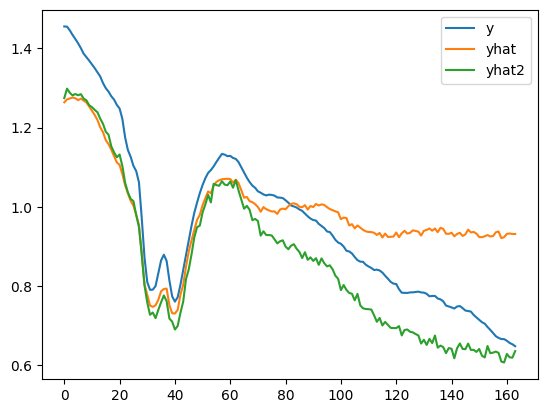

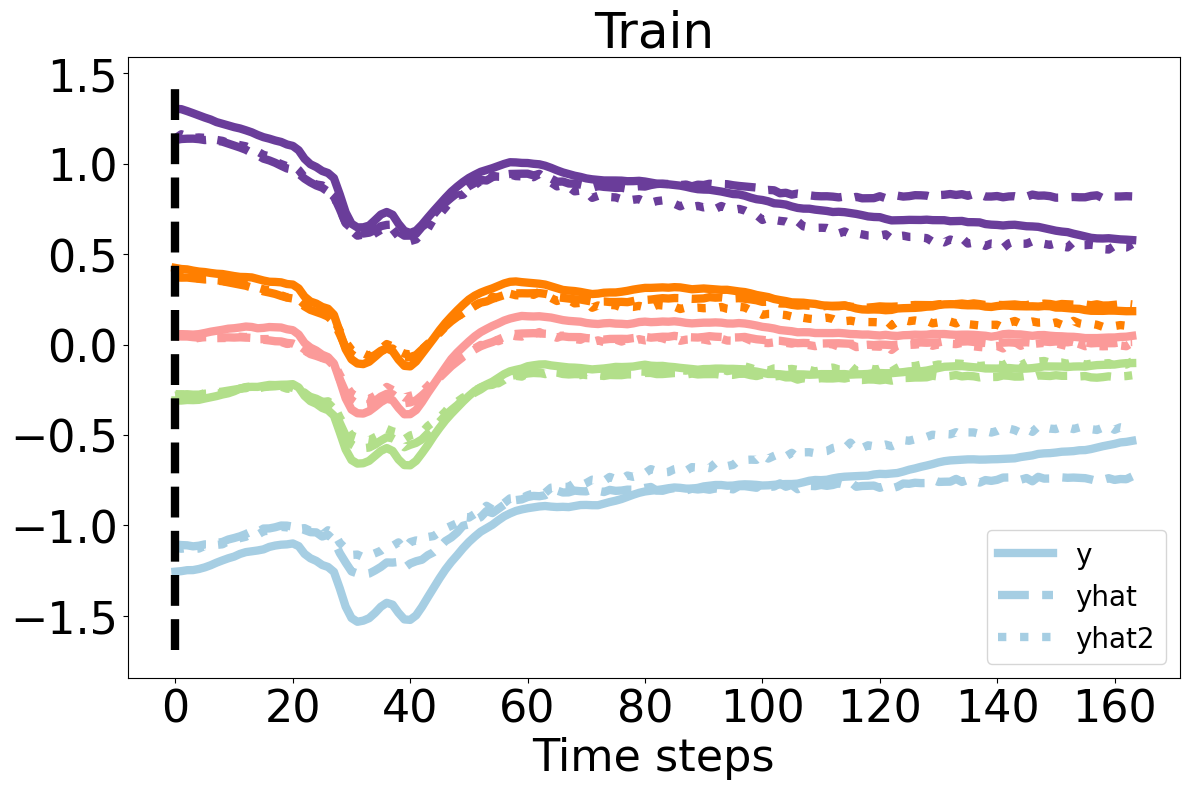

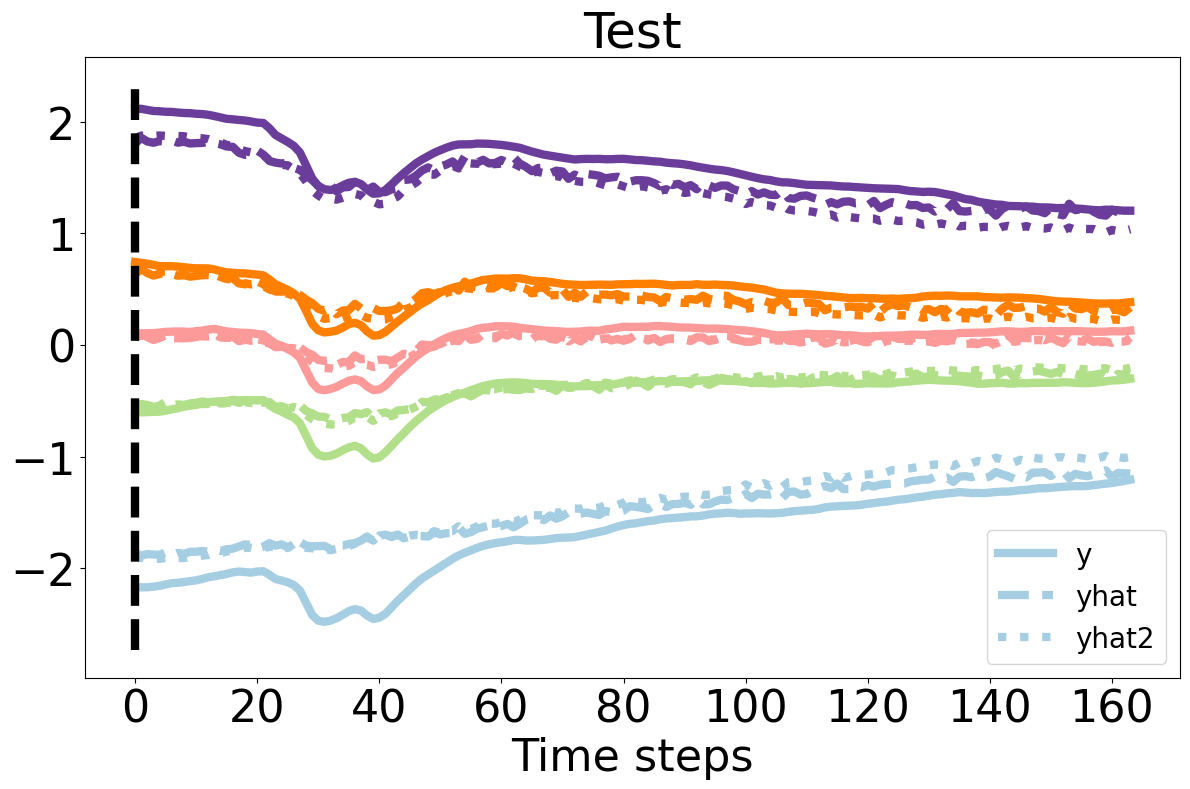

In [67]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])             
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])                    
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)

